# Building business cases better -- using distributions 


Some basic imports. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.ticker import FuncFormatter
import sys
import pandas as pd

sys.path.append("..")
from dataclasses import dataclass, asdict

In [3]:
from mcbizmod.DistP import DistP
from mcbizmod.MCBizMod import MCBizMod

In [4]:
sns.set_theme()
sns.set_context('paper')

In [5]:
from matplotlib.ticker import FuncFormatter


def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x * 1e-6)


formatter = FuncFormatter(millions)

This is a simulation, so we need to instantiate a simulation 'run', which controls the length of the randomly generated arrays. 

## What is a distribution? 

When we use the term distribution in statistics, we usually mean a probability distribution.  The distribution is, literally, a statistical representation of the data. On a technical level, it's an representation of an array of data. 

## Why do we care about business cases and distributions? 
Oftentimes when people make a business cases, they make static or fixed assumptions about the behavior. While convenient, this is a bad idea. Here's where distributions come in. 

Ultimately, each parameter isn't static, it's a distribution of possibilities, for which we need to determine the fraction of times for which an event happens. 

We've built a basic dataclass constructor to track the assumptions made and make your business cases repeatable, inspectable, and (more) accurate. Or at least, wrong in a quantifiable way:). 

## What are some of the fundamental 'tenants' of using mcbizmod? 

1. Pull your population directly from the data whenever possible

2. Where possible, _use the whole distribution_. 
    - Data is data. It's wild, but you benefit from using the whole distribution because IT'S data! 
    
5. When in doubt, use lognormal distributions to estimate. 
    - most biologic phenomena follow a lognormal distribution (this came from a colleauge of mine [lognormal and bioscience](https://stat.ethz.ch/~stahel/lognormal/bioscience.pdf)). 

## Cool, so what do we do? 

The purpose of mcbizmod is to characterize the variables/parameters that you're using in your business case using distributions. Then, to re-create the business model and monte-carlo sample the business model at the range of possibilities.

### The pitch 
Let's assume that our business case involves a medical intervention for a common chronic medical condition like Congestive heart failure (CHF). CHF is a complex, progressive condition that affects the heart’s ability to effectively pump blood to the body. Numerous studies have found that comprehensive education programs can reduce the rates of CHF related re-admissions. We propose to deliver education material, inspired by the American Heart Association and the American College of Cardiology, to reduce admissions among members with CHF. These materials will focus on patient self-care and patient self-monitoring.

Delivering educational materials on self-care and self-monitoring may reduce the rates of admissions with little to no increase in medical or pharmacy utilization.

### The Business Case
*The universe*

This pilot will target a population of members with CHF, who are at high risk of hospitalization over the next 12 months based on previous analyses. For this pilot, we select the top 30k members by risk of hospitalization.

*Exclusions*

Due to competing outreach related to preventing readmissions, we exclude members who have been hospitalized in the past 6 months. To eliminate the risk of sending materials that contradict care managers, we exclude members in care management programs, including the Healthy Heart VBID program.

### Assumptions for our simulation
- 5k simulations
- membership is lognormally distributed with a mean of 500, 200. 
- spend distribution is described as normally distributed with a mean of 6088 and a std of 2000. 
- Let's assume we need/have a model to identify members at risk. Let's assume that the models precision is uniformly distributed between ~0.30-0.40%.
- Let's assume that the prevalence of CHF is lognormally distributed with a mean of 6% and a standard deviation of ~1%.
- the prevalence of CHF admissions normally distributed with a mean of 20% and a standard deviation of ~2%.
- the engagement estimate is normally distributed with a mean of ~20% and a standard deviation of ~5%.
- the treatment effect is estimated to be normally distributed with a mean of 15% reduction in hospitalization rate and a standard deviation of 10%
- Let's assume that the price is \$2.5 per member outreached.
- Let's assume 1:1 treatment-control ratio for pilot. 

#### A note on fitting distributions. 

you can use the distp class to fit a given amount of data. In accordance with (1) above, you should do this _a lot_. The example I show below does not use data (for speed, mostly). 

In [6]:
# assume this treatment effect data came from an experiment
data_array = np.array([
    0.1243272, 0.02841775, 0.02462303, 0.05596238, 0.02816799, 0.06737527,
    0.08744445, 0.05503281, 0.06467202, 0.06707346, 0.12590284, 0.04279422,
    0.06179317, 0.05264741, 0.00944362, 0.02500023, 0.15752293, 0.02699168,
    0.04178847, 0.01391412, 0.04602457, 0.0596269, 0.06603306, 0.08619834,
    0.02477823, 0.2167056, 0.04017278, 0.03583264, 0.09153694, 0.03640167,
    0.02588049, 0.09159757, 0.07308884, 0.04771209, 0.09371187, 0.05632816,
    0.00991528, 0.04369652, 0.03447077, 0.03877374, 0.10061553, 0.05931281,
    0.07819679, 0.05195733, 0.11171881, 0.10992641, 0.0635759, 0.11434518,
    0.05556813, 0.05661915
])

You can then fit a distribution. Make sure to give it a name, a lever, and specificy `distfunc` as `fitted`, pass a `size` or the default will be 5000, and then pass `samples` being the array. 

In [7]:
fitted_tre = DistP(name='treatment effect',
                   lever='lever 1',
                   distfunc='fitted',
                   bounds=[0.0, 1],
                   size=20,
                   samples=data_array)

#### Simulations:

In [8]:
size = 5_000

#### Membership:
In this example, we're going to assume a log-normal distibution of plan sizes centered about 500 people. However, we're going to pass bounds to set the min and max plan size to constrain things. 

In [9]:
membership = DistP(name='membership',
                   lever='lever 1',
                   distfunc=np.random.uniform,
                   bounds=[0, 2e9],
                   kwargs={
                       'low': 2e6,
                       'high': 2e6,
                       'size': size
                   })

Let's take a look at what's embedded in the instantiated dataclass by checking out the `.__dict__` output.  

In [10]:
membership.__dict__

{'name': 'membership',
 'lever': 'lever 1',
 'segment': 'default segment',
 'distfunc': <function RandomState.uniform>,
 'bounds': [0, 2000000000.0],
 'bound_method': 'drop_recursive',
 'size_kwd': 'size',
 'kwargs': {'low': 2000000.0, 'high': 2000000.0, 'size': 5000},
 'size': 5000,
 'samples': array([2000000., 2000000., 2000000., ..., 2000000., 2000000., 2000000.]),
 'samples_mean': 2000000.0,
 'samples_median': 2000000.0,
 'samples_std': 0.0,
 'samples_percentiles': [2000000.0,
  2000000.0,
  2000000.0,
  2000000.0,
  2000000.0],
 'samples_len': 5000}

There's a lot of things embedded in the dict. The most important attributes are `samples`, which contains an array of length `size` (in this case: 5000). These samples are randomly generated. 

There are also a few convenience functions in this class that that help us, like `displot` and `kdeplot`. 

A histogram (distribution plot-style). 

<AxesSubplot:ylabel='Count'>

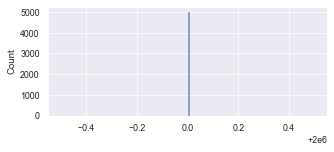

In [11]:
fig, ax = plt.subplots(figsize=(5, 2))
membership.histplot(**{'ax': ax, 'bins': 100})

#### Spend:
spend distribution is described as normally distributed with a mean of 6088 and a std of 2000. In reality, it's much, much more broad. However, we can constrain the bounds to a realistic range (which is a bad idea).  


In [12]:
spend = DistP(name='spend',
              lever='lever 1',
              distfunc=np.random.normal,
              bounds=[0, 6e5],
              kwargs={
                  'loc': 250,
                  'scale': 30,
                  'size': size
              })

<AxesSubplot:ylabel='Probability'>

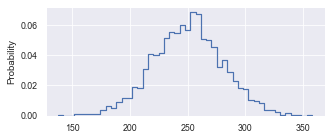

In [13]:
fig, ax = plt.subplots(figsize=(5, 2))
spend.histplot(
    **{
        'cumulative': False,
        'stat': "probability",
        "fill": False,
        "element": 'step',
        'ax': ax
    })

<AxesSubplot:ylabel='Density'>

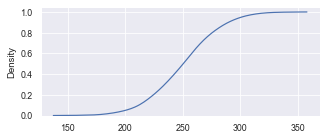

In [14]:
fig, ax = plt.subplots(figsize=(5, 2))
spend.kdeplot(**{'cumulative': True, 'ax': ax, 'cut': 0})

#### Prevalence:
The number of members with the actual thing we want to intervene upon. In this case, the prevalence of CVD-admissions in the population. It's typically better to get this from data (but I'm lazy and don't have time). 

In [15]:
prevalence = DistP(name='prevalence',
                   lever='lever 1',
                   distfunc=np.random.lognormal,
                   bounds=[0.002, 1],
                   kwargs={
                       'mean': np.log(0.02),
                       'sigma': np.log(2),
                       'size': size
                   })

In [16]:
prevalence.__dict__

{'name': 'prevalence',
 'lever': 'lever 1',
 'segment': 'default segment',
 'distfunc': <function RandomState.lognormal>,
 'bounds': [0.002, 1],
 'bound_method': 'drop_recursive',
 'size_kwd': 'size',
 'kwargs': {'mean': -3.912023005428146,
  'sigma': 0.6931471805599453,
  'size': 5002},
 'size': 5000,
 'samples': array([0.01489565, 0.02418749, 0.01935063, ..., 0.02214019, 0.02787451,
        0.00678537]),
 'samples_mean': 0.03,
 'samples_median': 0.02,
 'samples_std': 0.02,
 'samples_percentiles': [0.002, 0.013, 0.021, 0.032, 0.359],
 'samples_len': 5000}

<AxesSubplot:ylabel='Probability'>

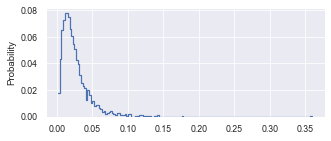

In [17]:
fig, ax = plt.subplots(figsize=(5, 2))
prevalence.histplot(
    **{
        'cumulative': False,
        'stat': "probability",
        "fill": False,
        "element": 'step',
        'ax': ax
    })

<AxesSubplot:ylabel='Probability'>

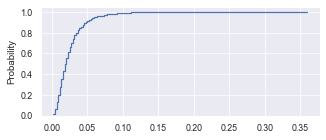

In [18]:
fig, ax = plt.subplots(figsize=(5, 2))
prevalence.histplot(
    **{
        'cumulative': True,
        'stat': "probability",
        "fill": False,
        "element": 'step',
        'ax': ax
    })

<AxesSubplot:ylabel='Density'>

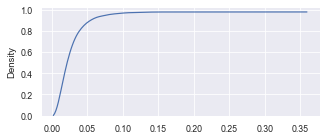

In [19]:
fig, ax = plt.subplots(figsize=(5, 2))
prevalence.kdeplot(**{'cumulative': True, 'ax': ax, 'cut': 0})

#### Engagement:

In [20]:
engagement = DistP(name='engagement',
                   lever='lever 1',
                   distfunc=np.random.normal,
                   bounds=[0.01, 1],
                   kwargs={
                       'loc': 0.05,
                       'scale': 0.05,
                       'size': size
                   })

<AxesSubplot:ylabel='Probability'>

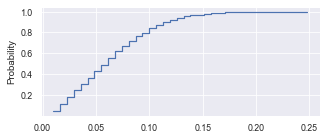

In [21]:
fig, ax = plt.subplots(figsize=(5, 2))
engagement.histplot(
    **{
        'cumulative': True,
        'stat': "probability",
        "fill": False,
        "element": 'step',
        'ax': ax
    })

<AxesSubplot:ylabel='Density'>

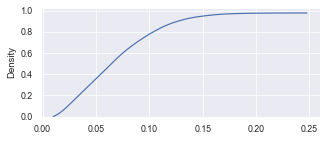

In [22]:
fig, ax = plt.subplots(figsize=(5, 2))
engagement.kdeplot(**{'cumulative': True, 'ax': ax, 'cut': 0})

#### Treatment effect:

In [23]:
treatment_eff = DistP(name='treatment effect',
                      lever='lever 1',
                      distfunc=np.random.lognormal,
                      bounds=[0.0, 1],
                      kwargs={
                          'mean': np.log(0.1),
                          'sigma': np.log(2),
                          'size': size
                      })

<AxesSubplot:ylabel='Probability'>

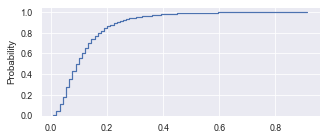

In [24]:
fig, ax = plt.subplots(figsize=(5, 2))
treatment_eff.histplot(
    **{
        'cumulative': True,
        'stat': "probability",
        "fill": False,
        "element": 'step',
        'ax': ax
    })

<AxesSubplot:ylabel='Density'>

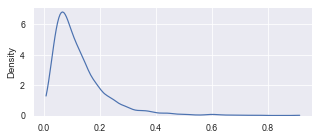

In [25]:
fig, ax = plt.subplots(figsize=(5, 2))
treatment_eff.kdeplot(**{'cumulative': False, 'ax': ax, 'cut': 0})

In [26]:
treatment_eff.samples.mean()

0.12701070147132057

#### Intervention Cost:

In [27]:
cost = DistP(name='intervention cost',
             lever='lever 1',
             distfunc=np.random.uniform,
             kwargs={
                 'low': 2.5,
                 'high': 2.5,
                 'size': size
             })

<AxesSubplot:ylabel='Count'>

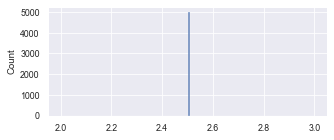

In [28]:
fig, ax = plt.subplots(figsize=(5, 2))
cost.histplot(**{'ax': ax, 'bins': 100})

## Creating a business case value lever

Instantiate a basic lever. Give it a name. 

In [29]:
MCbiz = MCBizMod('ngTDC')

In [30]:
membership

DistP(name='membership', lever='lever 1', segment='default segment', distfunc=<built-in method uniform of numpy.random.mtrand.RandomState object at 0x1285deb40>, bounds=[0, 2000000000.0], bound_method='drop_recursive', size_kwd='size', kwargs={'low': 2000000.0, 'high': 2000000.0, 'size': 5000}, size=5000, samples=array([2000000., 2000000., 2000000., ..., 2000000., 2000000., 2000000.]), samples_mean=2000000.0, samples_median=2000000.0, samples_std=0.0, samples_percentiles=[2000000.0, 2000000.0, 2000000.0, 2000000.0, 2000000.0])

In [31]:
MCbiz.add_dist_params(
    [prevalence, membership, spend, treatment_eff, engagement, cost])

MCBizMod(name='ngTDC')

Note that this name means that any distributions for which the value lever name doesn't match will not be rejected, but tracked! Let's try this out. 

In [32]:
cost2 = DistP(name='intervention cost',
              lever='lever 2',
              distfunc=np.random.uniform,
              kwargs={
                  'low': 2.5,
                  'high': 2.5,
                  'size': size
              })

In [33]:
MCbiz.add_dist_params([cost2])

MCBizMod(name='ngTDC')

See! Neat. 

### Creating a business case
You can create any number of named entities using this method. However, for each value lever, there can be a distribution of possibilities. Please note that we distregard the realism of some of these cases, or any of the conditionality of the downstream cases upon selection. We assume that each of these are completely independant samples. 

So, let's go ahead and create a business case for 'mcs'. 

It's pretty easy. use the `._value_lever` method to pass along 3 things, the name of the distribution, the operator, and the name of the attribute you want to name it as e.g., 'mcs'. 

Note that `base` is a special operator that denotes the base distribution from which things start. It could be any distribution. However, typically it's the membership. 

In [34]:
MCbiz.value_lever(dist_name='membership',
                  operator='base',
                  lever='lever 1',
                  segment='default segment',
                  label='mcs')

MCbiz.value_lever('prevalence', '*', 'lever 1', 'default segment', 'mcs')
MCbiz.value_lever('engagement', '*', 'lever 1', 'default segment', 'mcs')
MCbiz.value_lever('treatment effect', '*', 'lever 1', 'default segment', 'mcs')
MCbiz.value_lever('spend', '*', 'lever 1', 'default segment', 'mcs')

MCBizMod(name='ngTDC')

Let's see what that did before driving on. 

Just like the distribution objects, the value lever has all the methods, including plotting. Let's take a look. 

Text(0.5, 0, 'MCS ($)')

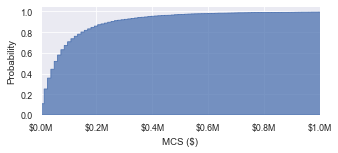

In [35]:
fig, ax = plt.subplots(figsize=(5, 2))
MCbiz.bizcase.get('lever 1').get('default segment').get('mcs').histplot(**{
    'cumulative': True,
    'stat': "probability",
    "element": 'step',
    'ax': ax
})
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(0, 1e6)
ax.set_xlabel('MCS ($)')

## More complex business cases using the bizmodel

Let's say you already have a bunch of distributions and value levers. Let's quickly set this up. 

Let's say you have 2 value levers. 
1. predicting members at elevated risk for re-admission for intersection with an RPM device that will decrease their liklihood to admit. 
2. a site of care opportunity, where 5% of a given procedure with a known cost will be decrease conditional on nudging members to a new location for service (e.g., health hub). 

In [36]:
TransformCHF = MCBizMod('Transform CHF')

### Value lever 1
predicting members at elevated risk for re-admission for intersection with an RPM device that will decrease their liklihood to admit. 

In [37]:
size = 100_000

In [38]:
membership1 = DistP(name='membership',
                    lever='avoided admissions',
                    distfunc=np.random.uniform,
                    bounds=[0, 2e9],
                    kwargs={
                        'low': 2e6,
                        'high': 2e6,
                        'size': size
                    })

In [39]:
prevalence1 = DistP(name='prevalence',
                    lever='avoided admissions',
                    distfunc=np.random.lognormal,
                    bounds=[0.002, 1],
                    kwargs={
                        'mean': np.log(0.02),
                        'sigma': np.log(2),
                        'size': size
                    })

In [40]:
treatment_eff1 = DistP(name='treatment effect',
                       lever='avoided admissions',
                       distfunc=np.random.lognormal,
                       bounds=[0.0, 1],
                       kwargs={
                           'mean': np.log(0.1),
                           'sigma': np.log(2),
                           'size': size
                       })

In [41]:
spend1 = DistP(name='spend',
               lever='avoided admissions',
               distfunc=np.random.normal,
               bounds=[0, 6e5],
               kwargs={
                   'loc': 5000,
                   'scale': 2000,
                   'size': size
               })

In [42]:
engagement1 = DistP(name='engagement',
                    lever='avoided admissions',
                    distfunc=np.random.normal,
                    bounds=[0.01, 1],
                    kwargs={
                        'loc': 0.05,
                        'scale': 0.05,
                        'size': size
                    })

In [43]:
cost1 = DistP(name='intervention cost',
              lever='avoided admissions',
              distfunc=np.random.uniform,
              kwargs={
                  'low': 100,
                  'high': 100,
                  'size': size
              })

In [44]:
model_precision1 = DistP(name='model precision',
                         lever='avoided admissions',
                         distfunc=np.random.uniform,
                         kwargs={
                             'low': 0.4,
                             'high': 0.6,
                             'size': size
                         })

Now let's add all these distributions into mcbizmod and create the value lever's business case for mcs. 

In [45]:
TransformCHF.add_dist_params([
    membership1, prevalence1, spend1, treatment_eff1, engagement1, cost1,
    model_precision1
])

MCBizMod(name='Transform CHF')

In [46]:
TransformCHF.value_lever('membership', 'base', 'avoided admissions',
                         'default segment', 'mcs')
TransformCHF.value_lever('prevalence', '*', 'avoided admissions',
                         'default segment', 'mcs')
TransformCHF.value_lever('model precision', '*', 'avoided admissions',
                         'default segment', 'mcs')
TransformCHF.value_lever('engagement', '*', 'avoided admissions',
                         'default segment', 'mcs')
TransformCHF.value_lever('treatment effect', '*', 'avoided admissions',
                         'default segment', 'mcs')
TransformCHF.value_lever('spend', '*', 'avoided admissions', 'default segment',
                         'mcs')

MCBizMod(name='Transform CHF')

### Value lever 2
a site of care opportunity, where 5% of a given procedure with a known cost will be decrease conditional on nudging members to a new location for service (e.g., health hub).

In [47]:
membership2 = DistP(name='membership',
                    lever='site of care play',
                    distfunc=np.random.uniform,
                    bounds=[0, 2e9],
                    kwargs={
                        'low': 2e6,
                        'high': 2e6,
                        'size': size
                    })

In [48]:
prevalence2 = DistP(name='prevalence',
                    lever='site of care play',
                    distfunc=np.random.lognormal,
                    bounds=[0.002, 1],
                    kwargs={
                        'mean': np.log(0.2),
                        'sigma': np.log(2),
                        'size': size
                    })

In [49]:
treatment_eff2 = DistP(name='treatment effect',
                       lever='site of care play',
                       distfunc=np.random.lognormal,
                       bounds=[0.0, 1],
                       kwargs={
                           'mean': np.log(0.05),
                           'sigma': np.log(2),
                           'size': size
                       })

In [50]:
# Let's assume it's ~$50 cheaper to get something at the MC.
spend2 = DistP(name='spend',
               lever='site of care play',
               distfunc=np.random.normal,
               bounds=[0, 6e5],
               kwargs={
                   'loc': 50,
                   'scale': 2000,
                   'size': size
               })

In [51]:
engagement2 = DistP(name='engagement',
                    lever='site of care play',
                    distfunc=np.random.normal,
                    bounds=[0.01, 1],
                    kwargs={
                        'loc': 0.1,
                        'scale': 0.05,
                        'size': size
                    })

In [52]:
cost2 = DistP(name='intervention cost',
              lever='site of care play',
              distfunc=np.random.uniform,
              kwargs={
                  'low': 1,
                  'high': 1,
                  'size': size
              })

Now let's add all these distributions into mcbizmod and create the value lever's business case for mcs. 

In [53]:
TransformCHF.add_dist_params(
    [membership2, prevalence2, spend2, treatment_eff2, engagement2, cost2])

MCBizMod(name='Transform CHF')

In [54]:
TransformCHF.value_lever('membership', 'base', 'site of care play',
                         'default segment', 'mcs')
TransformCHF.value_lever('prevalence', '*', 'site of care play',
                         'default segment', 'mcs')
TransformCHF.value_lever('engagement', '*', 'site of care play',
                         'default segment', 'mcs')
TransformCHF.value_lever('treatment effect', '*', 'site of care play',
                         'default segment', 'mcs')
TransformCHF.value_lever('spend', '*', 'site of care play', 'default segment',
                         'mcs')

MCBizMod(name='Transform CHF')

### Great! Now let's sum over the value levers

Text(0.5, 0, 'MCS ($)')

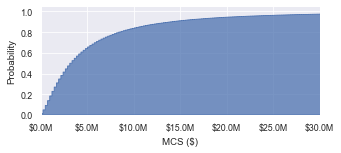

In [55]:
fig, ax = plt.subplots(figsize=(5, 2))
TransformCHF.sum_over_levers_segments(['mcs'], ['default segment']).histplot(**{
    'cumulative': True,
    'stat': "probability",
    "element": 'step',
    'ax': ax
})
ax.set_xlim(0, 3e7)
ax.set_xlabel('MCS from site of care play ($)')
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('MCS ($)')

### Cool, what if I wanted to spit out all the assumptions at once? 

Let's spit out the assumptions

In [58]:
TransformCHF.bizcase['avoided admissions']['default segment'].keys()

dict_keys(['mcs'])

In [60]:
TransformCHF.return_assumptions(
    drop_cols=['bound_method', 'size_kwd', 'samples', 'kwargs'])

,name,lever,segment,distfunc,bounds,size,samples_mean,samples_median,samples_std,samples_percentiles
0,membership,avoided admissions,default segment,<built-in method uniform of numpy.random.mtran...,"[0, 2000000000.0]",5000,2000000.0,2000000.0,0.0,"[2000000.0, 2000000.0, 2000000.0, 2000000.0, 2..."
0,prevalence,avoided admissions,default segment,<built-in method lognormal of numpy.random.mtr...,"[0.002, 1]",5000,0.03,0.02,0.02,"[0.002, 0.013, 0.02, 0.032, 0.444]"
0,spend,avoided admissions,default segment,<built-in method normal of numpy.random.mtrand...,"[0, 600000.0]",5000,5044.71,5032.63,1954.58,"[11.084, 3684.594, 5032.63, 6375.355, 12972.68]"
0,treatment effect,avoided admissions,default segment,<built-in method lognormal of numpy.random.mtr...,"[0.0, 1]",5000,0.13,0.1,0.1,"[0.006, 0.062, 0.1, 0.159, 0.99]"
0,engagement,avoided admissions,default segment,<built-in method normal of numpy.random.mtrand...,"[0.01, 1]",5000,0.07,0.06,0.04,"[0.01, 0.039, 0.063, 0.093, 0.251]"
0,intervention cost,avoided admissions,default segment,<built-in method uniform of numpy.random.mtran...,"[0, 1000000.0]",5000,100.0,100.0,0.0,"[100.0, 100.0, 100.0, 100.0, 100.0]"
0,model precision,avoided admissions,default segment,<built-in method uniform of numpy.random.mtran...,"[0, 1000000.0]",5000,0.5,0.5,0.06,"[0.4, 0.45, 0.5, 0.55, 0.6]"
0,membership,site of care play,default segment,<built-in method uniform of numpy.random.mtran...,"[0, 2000000000.0]",5000,2000000.0,2000000.0,0.0,"[2000000.0, 2000000.0, 2000000.0, 2000000.0, 2..."
0,prevalence,site of care play,default segment,<built-in method lognormal of numpy.random.mtr...,"[0.002, 1]",5000,0.24,0.2,0.17,"[0.01, 0.124, 0.198, 0.315, 1.0]"
0,spend,site of care play,default segment,<built-in method normal of numpy.random.mtrand...,"[0, 600000.0]",5000,1617.06,1370.73,1220.08,"[0.006, 649.137, 1370.73, 2328.402, 9673.206]"
